# Time Series Prediction

Due to the sequential charasteristics of RNNs, they can be used for time series prediction task. A time series is a series of data points indexed in time order. One example of time series is stock prices at regular intervals of time (hourly, daily, etc.). There have been many attempts to forecast stocks market, some belive predicting the market is impossible because of its total random behaviour, while some (mainly stocks technical analysts) belive not 100% accurate, but it is partly predictable, as they say "history repeats itself" (this phrase indicates that there might be some repetitive patterns in market's behaviour). 

In this practice, we are going to discover ourselves whether it is possible or not, whether we are going to be rich or broke :)  

## Stocks Prediction Using LSTM

LSTMs can be used for modeling time series (such as stocks market) as they are capable of remembering past information. Stock price prediction is similar to any other machine learning problem where we are given a set of features and we have to predict a corresponding value, in this case our features are the closing prices of stocks in the past 60 days and we want to predict next closing price. We can use LSTM to model this 60 days sequence by a hidden state as we do in all other sequence modeling problems:

<p align="center"><img src="https://drive.google.com/thumbnail?id=1hml7fG9_GKDLH1068Wq_Jk-D09FtQk17&sz=w1000-h1000" width="800"/></p>

</br>

We are going to solve these two following problems:
* 1 . Predicting the exact price at time $T_i$ given prices at times $T_{i-60}$, ..., $T_{i-1}$

* 2 . A simplified version of previous problem, predicting the direction of price at time $T_i$ (whether it is increasing or decreasing) given prices at times $T_{i-60}$, ..., $T_{i-1}$


So the first task is a regression and the second one is a classification problem.


### 1. Predicting The Exact Price

**DATA:**

The data that we are going to use are from ***Yahoo Finance*** (a place to look up stock market data and company news). We can accsess historical market data from *Yahoo Finance* using python ***yfinance*** module. 

Let's install *yfinance* module first:

In [6]:
from IPython.display import clear_output

# !pip install yfinance

clear_output()

For training our algorithm, we will be using the Apple stock prices from 1st January 2014 to 1st January 2018. In order to evaluate the performance of the algorithm, we will be using the prices from 1st January 2018 to 1st January 2019. 

Let's get the data and visualise it:

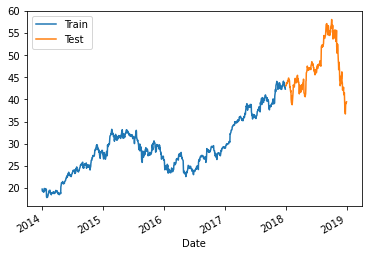

In [7]:

import matplotlib.pyplot as plt
import yfinance as yf  

train_data = yf.download('AAPL','2014-01-01','2018-01-01')
test_data = yf.download('AAPL','2018-01-01','2019-01-01')

train_data.Close.plot()
test_data.Close.plot()
plt.legend (["Train", "Test"])

clear_output()
plt.show()

As you can see our data is just a sequence of numbers ordered by time. 

In order to normalize our data we scale them between 0 and 1: 

In [8]:
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
scaler = MinMaxScaler(feature_range = (0, 1)).fit(train_data.Close.values.reshape(-1, 1))

train_scaled = scaler.transform(train_data.Close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))  

print ("train_scaled.shape :", train_scaled.shape)
print ("test_scaled.shape :", test_scaled.shape)

train_scaled.shape : (1007, 1)
test_scaled.shape : (251, 1)


Now we create our input output pairs from our sequence:

In [9]:
train_features_set = []  
train_labels = []  
for i in range(60, train_scaled.shape[0]):  
    train_features_set.append(train_scaled[i-60:i, 0])
    train_labels.append(train_scaled[i, 0])

We need to convert these lists to the numpy arrays before we can use them for training. Then in order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is 1007 in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of indicators. Since we are only using one feature, i.e Closing price, the number of indicators will be one.

In [10]:
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))

Now let's create and train a simple model, our model has a stack of 4 lstm layers and a single output layer: 

In [11]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))

# we have a single output so this layer has 1 unit
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(train_features_set, train_labels, epochs = 100, batch_size = 30)

clear_output()

Now we create our test features set similar to what we did with our training set:

In [12]:
test_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))  

test_features_set = []  
for i in range(60, test_scaled.shape[0]):  
    test_features_set.append(test_scaled[i-60:i, 0])
    
test_features_set = np.array(test_features_set)  
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

And finaly let's see the results:

6/6 [==============================] - 2s 77ms/step


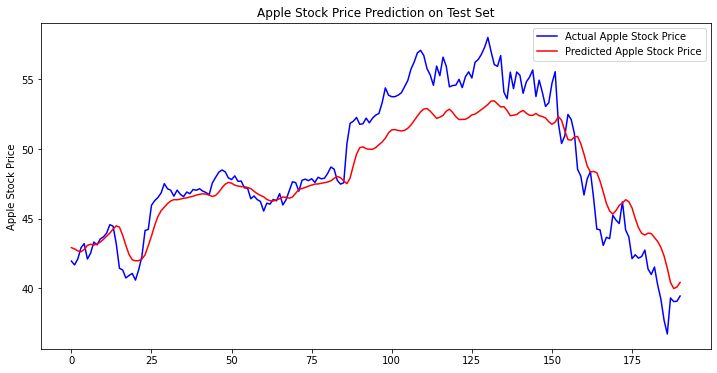

In [13]:
predictions = model.predict(test_features_set)
predictions = scaler.inverse_transform(predictions)  
  
plt.figure(figsize=(12,6))
plt.plot(test_data.Close.values[60:], color='blue', label='Actual Apple Stock Price')  
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction on Test Set')    
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()

* At first sight, it seems the predictions are following  pretty well the actual trends. What do you think about the result? Are you willing to risk using this predictions in real world? 

*No. Although it follows the actual trend but it has some delay to detect the trend.
for example in the first valley of plot, it first predicted the increasing trend but the actual trend was opposite and after it saw the first data which had decreasing trend, it tried to adopt to it.*

### 2. Predicting The Direction

Previous model can be evaluated  just visually. We can evaluate a classification task using its special measures (such as f-score or accuracy) much better than a regression task. So in order to finaly decide whether the stocks market prediction is practical or not, we define this second task.

Implement a model similar to previous one, this time the task is to predict whether the price is going to increase or decrease (output will be either 1 or 0 respectively) at time $T_i$ given prices at times $T_{i-60}$, ..., $T_{i-1}$ :

In [14]:
train_dir_labels = []
for i in range(60, train_scaled.shape[0]): 
    if(train_scaled[i]>train_scaled[i-1]):
        train_dir_labels.append(1)
    else:
        train_dir_labels.append(0)
train_dir_labels = np.array(train_dir_labels).reshape(-1, 1)
########################################

model = Sequential()
model.add(LSTM(units=50, activation = 'relu', return_sequences=True, input_shape=(train_features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True, activation = 'relu'))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True,  activation = 'relu'))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, activation = 'relu'))  
model.add(Dropout(0.2))

model.add(Dense(units = 1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model.fit(train_features_set, train_dir_labels, epochs = 100, batch_size = 30)

clear_output()

########################################

Evaluate your trained model using the test set and report accuracy and f1-score your model archived: 

In [15]:
########################################

test_dir_labels=[]
for i in range(60, test_scaled.shape[0]): 
    if(test_scaled[i]>test_scaled[i-1]):
        test_dir_labels.append(1)
    else:
        test_dir_labels.append(0)
test_dir_labels = np.array(test_dir_labels).reshape(-1, 1)

predictions = model.predict(test_features_set)

predictions = np.floor(predictions*2)

acc = model.evaluate(test_features_set, test_dir_labels)
TP = sum(np.multiply(predictions,test_dir_labels))
FP = sum(np.multiply(predictions,1-test_dir_labels))
FN = sum(np.multiply(1-predictions,test_dir_labels))

p = TP/(TP+FP)
r = TP/(TP+FN)
f = 2*p*r/(p+r)
print('f1-score:', f)

########################################

6/6 [==============================] - 1s 31ms/step - loss: 0.6930 - accuracy: 0.5340
f1-score: [0.69624573]


Do not worry if your results are not as promising as before :))
* Comparing new results with previuos ones, why do you think this happens? Doesn't this task supposed to be an easier version of the previous one (if you are able to predict the actual price, you are already able to predict the direction of price trend)? Explain your toughts:


*As we discussed earlier, the model predictions have some dealy so it is evident that the classification acuuracy has lower acuracy than we expected.*

* Intuitively explain what kind of properties do you think a time series need to have in order to be predictable? 

*Trends / Seasonal or Nonseasonal cycles*